## Symbolic data processing, Turkish music case

In this notebook, the SymTr data (Turkish Makam Music Symbolic Data Collection) (http://compmusic.upf.edu/node/140 , https://github.com/MTG/SymbTr) is used. Here we demonstrate accessing pieces in a specific form and makam, reading a specific a section of the form and ploting the melodic curves. The makams are chosen to apply the same scale but different melodic progressions ('seyir'). 


The following steps are carried:
- Downloading SymbTr data from the github repo
- Printing a list of makams and forms sorted with respect to the number of files in those categories
- Plotting melodic curves from the first sections in saz-semaisi form in two makams: rast and mahur.


In [1]:
#Imports
import urllib.request
import zipfile
import os, sys,shutil
import numpy as np
import matplotlib.pyplot as plt

### Downloading SymbTr data

In [2]:
dataDir = '../data/compMusicDatasets/turkishMakam/'
downloadData = True#set to False if you already downloaded the data

if downloadData:
    if not os.path.exists(dataDir):#creating the directory
        os.mkdir(dataDir);
    url = 'https://github.com/MTG/SymbTr/archive/v2.0.0.zip'
    filename = 'SymbTr-2.0.0.zip'   
    #Downloading the zip file from the url
    urllib.request.urlretrieve(url, filename)
    #Unzipping to a specific folder
    zip_ref = zipfile.ZipFile(filename, 'r')
    zip_ref.extractall(dataDir)
    zip_ref.close()
    os.remove(filename)#Removing the zip file
    final_data_dir = os.path.join(dataDir, filename.replace('.zip',''))
    print('Data downloaded and unzipped to: %s' % final_data_dir)
else:#assuming data was downloaded in a previous call
    final_data_dir = os.path.join(dataDir, '/SymbTr-2.0.0/')

#### Grouping files with respect to makams, printing a short sorted table


In [3]:
#Function definitions
def printSortedList(file_dict, numCategories = 5):
    '''Prints list of categories sorted in terms of number of files contained
    
    Args:
        file_dict (dict): dictionary containing categories mapped to file list
        numCategories (int): number of categories  
    '''
    categories = list(file_dict.keys())
    
    numFiles_category = np.zeros((len(categories),), dtype=int)
    for index in range(len(categories)):
        numFiles_category[index] = len(file_dict[categories[index]])
    
    sortedIndexes=np.flipud(np.argsort(numFiles_category))#highest to lowest sorting
    for index in range(numCategories):
        print(categories[sortedIndexes[index]],' :\t', numFiles_category[sortedIndexes[index]])

def constructFileDict(fileList, tokenIndex):
    '''Constructs/returns dictionary that maps categories to file lists
    
    The file name is split into tokens accorindg to the format of SymbTr slug:
    makam--form--usul--title--composer
    
    Args:
        fileList (list): file list
        tokenIndex (int): category to be used for grouping the files
            Example: tokenIndex=0, the dictionary returned contains files grouped
            in makam categories (keys: makam name, values: file list for the makam).
    Outputs:
        file_dict (dict): dictionary makking categories to file lists    
    '''
    file_dict = dict()
    for txtFile in fileList:
        tokens = txtFile.split('--')
        category = tokens[tokenIndex]

        files4category = file_dict.get(category)
        if files4category == None:
            files4category = [txtFile]
        else:
            files4category.append(txtFile)
        file_dict[category] = files4category
    
    return file_dict


In [4]:
#Constructing file lists and printing
txtFilesList = os.listdir(final_data_dir + 'txt/')
makamsFileList = constructFileDict(txtFilesList, 0)
formsFileList = constructFileDict(txtFilesList, 1)

print('-------------------------------------')
print('Most frequently used modes in score collection ')
printSortedList(makamsFileList, 10)
print('-------------------------------------')
print('Most frequently used forms in score collection ')
printSortedList(formsFileList, 10)

-------------------------------------
Most frequently used modes in score collection 
hicaz  :	 160
nihavent  :	 128
ussak  :	 119
rast  :	 110
huzzam  :	 96
segah  :	 93
huseyni  :	 91
mahur  :	 88
hicazkar  :	 79
kurdilihicazkar  :	 70
-------------------------------------
Most frequently used forms in score collection 
sarki  :	 991
turku  :	 295
seyir  :	 156
kupe  :	 120
pesrev  :	 93
sazsemaisi  :	 82
aranagme  :	 73
ilahi  :	 41
beste  :	 39
yuruksemai  :	 38


### Plotting melodic curves
Below we plot first sections in saz-semaisi form in two makams: rast and mahur. 

In [5]:
def readInstrumentalSection(filePath, sectionStartStr = '1. HANE'):
    '''Reading notes of an instrumental section
    
    Args:
        filePath (str): file path
        sectionStartStr (str): section start label. 
            The section boundaries are marked in the lyrics column with specific indicators.
            Example: In saz-semaisi, '1. HANE' refers to the A section
    Outputs:
        notesSequence (list): note sequence as a list of tuples (midi number, duration) 
    '''
    file = open(filePath,'r')
    content = file.read()
    lines = content.split('\n')
    #Reading content
    notesSequence = []
    inSection = False
    for line in lines[1:]:#skipping the first line
        tokens = line.split('\t')
        if(len(tokens) > 8):
            lyrics = tokens[11]
            if (not inSection) and (sectionStartStr in line):
                inSection = True
            elif inSection and len(lyrics) > 0:#any lyrics non-empty is considered a section-end if section is already started
                inSection = False

            if inSection:
                intervalInHc = int(tokens[4])
                if intervalInHc > 0:
                    midiNumber = intervalInHc*(1200/53)/100#conversion from Holderian commas to midi no
                else:
                    midiNumber = -1#pause represented with midi no = -1
                notesSequence.append((midiNumber, int(tokens[8])))
    return notesSequence

def melodicCurveFromNotesSequence(notesSequence, totalNumPoints = 1000):
    '''Constructing melodic curve from note sequence with a fixed size 
    
    Duration is scaled accordingly to match totalNumPoints
    
    Args:
        notesSequence (list): note sequence as a list of tuples (midi number, duration)
        totalNumPoints (int): total number of points to represent the melodic curve
    Outputs:   
        numpy array containing samples(in midi numbers) of a melody sequence
    '''
    totalDuration = 0
    for (note,duration) in notesSequence:
        totalDuration += duration
    
    durationUnit = totalDuration/totalNumPoints
    melograph = []
    for (note,duration) in notesSequence:
        if(note > 0):#pauses are discarded
            numPoints = int(duration/durationUnit)#due to this rounding, totalNumPoints will not be exactly matched
            melograph += ([note]*numPoints)
    return np.array(melograph)

Files in makam  rast  and form:  sazsemaisi
['rast--sazsemaisi--aksaksemai----benli_hasan_aga.txt', 'rast--sazsemaisi--aksaksemai----kantemiroglu.txt'] 

Files in makam  mahur  and form:  sazsemaisi
['mahur--sazsemaisi--aksaksemai----gazi_giray_han.txt', 'mahur--sazsemaisi--aksaksemai----nikolaki.txt', 'mahur--sazsemaisi--aksaksemai----refik_talat_alpman.txt', 'mahur--sazsemaisi--aksaksemai--bahar_1--goksel_baktagir.txt'] 



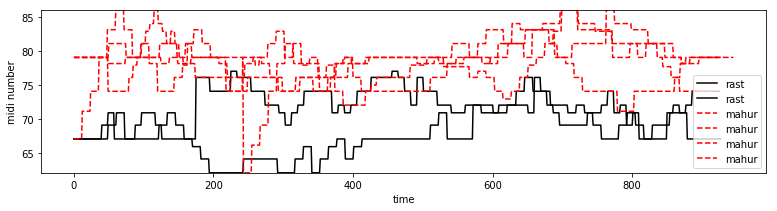

In [6]:
def formFileListForMakamAndForm(fileList, makam, form):
    '''Selects/returns a file list ( as a subset from the whole list: 'fileList') 
    given the filters: makam(str) and form(str)'''
    selectedFiles = []
    for txtFile in fileList:
        if((makam == txtFile.split('--')[0]) and (form == txtFile.split('--')[1])):
            selectedFiles.append(txtFile)
    return selectedFiles

#Let's pick two makams only differing in seyir and plotting melodic curves 
# for first sections in the sazsemaisi form
makams = ['rast','mahur']
form = 'sazsemaisi'
sectionStartStr = '1. HANE'#section's start indicator (in lyrics)

plt.figure(figsize = (13, 3))
colors = ['k','r--','b.','g.']#plotting color options for different makams
minInterval = 400#a high interval value to be updated with min value observed
maxInterval = 0#a low interval value to be updated with max value observed
for index in range(len(makams)):
    makam = makams[index]
    selectedFileList = formFileListForMakamAndForm(txtFilesList, makam, form)
    print('Files in makam ', makam, ' and form: ', form)
    print(selectedFileList, '\n')
    for symbTrFile in selectedFileList:
        #Reading notes of a section (section starting with sectionStartStr in lyrics, ending with any non-empty lyric)
        notesSequence=readInstrumentalSection(final_data_dir + '/txt/' + symbTrFile, sectionStartStr)
        if(len(notesSequence) > 0):
            #print(symbTrFile)
            #print('-----------------------')
            melograph = melodicCurveFromNotesSequence(notesSequence)
            plt.plot(melograph,colors[index], label = makam)
            minInterval = min(np.min(melograph), minInterval)
            maxInterval = max(np.max(melograph), maxInterval)

plt.ylim([minInterval, maxInterval])
plt.ylabel('midi number')
plt.xlabel('time')
plt.legend()

#### Note that the midi numbers are fractional. Here is part of a note sequence

In [7]:
print('Sample note sequence:')
print('List of (midi number, duration), midi=-1 refers to silence','\n')
print(notesSequence[:10])

Sample note sequence:
List of (midi number, duration), midi=-1 refers to silence 

[(79.0188679245283, 1000), (74.0377358490566, 500), (74.0377358490566, 125), (76.0754716981132, 125), (77.88679245283019, 125), (79.0188679245283, 125), (81.0566037735849, 125), (82.86792452830188, 125), (84.0, 125), (86.03773584905659, 125)]
